# Whitening transform
This notebook explores the effects of the *whitening transform*
(and its subroutine, the *Cholesky decomposition*)
on a few isolated example inputs.

### Cholesky decomposition
Decompose a matrix $M$ into two matrices $W$ of the same shape,
such that
$M = WW^{\top}$.

Note that $M$ must be
1. Symmetric
2. Positive definite
(In the example below, a covariance matrix is used.
These are always symmetric and positive definite.)

Also, $W$ is always lower triangular (i.e. entries
above the main diagonal are always 0).

It is supposedly faster than the Eigenvalue-decomposition.
PyTorch implements both only on the CPU,
so I doubt either is particularly fast to use in Neural Networks.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from rolim.tools.stats import sample_covar
from rolim.tools.testing import assert_tensor_eq
from rolim.whitening.whitening import whiten, whiten_naive

RNG = np.random.default_rng()

We begin with constructing a random
matrix that is symmetric and positive definite.
Covariance matrices always satisfy those requirements,
so compute the covariance matrix of a random collection of vectors:

In [2]:
shape = (3, 10)
elements = [x for x in range(shape[0]*shape[1])]
elements = RNG.permutation(elements)
sample = torch.tensor(elements, dtype=torch.float).reshape(shape)
m = sample_covar(sample)
m

tensor([[ 81.2111,  19.7556,  11.0889],
        [ 19.7556,  79.9556, -34.4889],
        [ 11.0889, -34.4889,  87.7333]])

In [3]:
w = torch.linalg.cholesky(m)
print(w)
print(w @ w.T)
torch.allclose(m, w@w.T)

tensor([[ 9.0117,  0.0000,  0.0000],
        [ 2.1922,  8.6689,  0.0000],
        [ 1.2305, -4.2896,  8.2352]])
tensor([[ 81.2111,  19.7556,  11.0889],
        [ 19.7556,  79.9556, -34.4889],
        [ 11.0889, -34.4889,  87.7333]])


True

Note that $W$ is always lower-triangular.
So we can use torch's dedicated `torch.triangular_solve()`:

In [4]:
output = torch.triangular_solve(torch.eye(w.shape[0]), w)
print(output)
output[0] @ w

torch.return_types.triangular_solve(
solution=tensor([[0.1110, 0.0000, 0.0000],
        [0.0000, 0.1154, 0.0000],
        [0.0000, 0.0000, 0.1214]]),
cloned_coefficient=tensor([[ 9.0117,  0.0000,  0.0000],
        [ 2.1922,  8.6689,  0.0000],
        [ 1.2305, -4.2896,  8.2352]]))


/tmp/ipykernel_4489/4119444925.py:1: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  output = torch.triangular_solve(torch.eye(w.shape[0]), w)


tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.2529,  1.0000,  0.0000],
        [ 0.1494, -0.5209,  1.0000]])

The above does not seem very accurate.
`torch.linalg.inv()` does better:

In [5]:
torch.linalg.inv(w) @ w

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [8.4971e-09, 2.0880e-09, 1.0000e+00]])

## Whitening transform on random 2D vectors
Experiment: sample random 2D vectors from multiple
(arbitrary) distributions, apply the whitening transform, and plot the results.

In [6]:
n1 = RNG.integers(low=10, high=100, dtype=int)
n2 = RNG.integers(low=10, high=100, dtype=int)
n3 = RNG.integers(low=10, high=100, dtype=int)

distr1 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([10, 10], dtype=torch.float), 
    covariance_matrix=torch.eye(2, dtype=torch.float)
)

distr2 = torch.distributions.multivariate_normal.MultivariateNormal(
    loc = torch.tensor([-1, 0], dtype=torch.float), 
    covariance_matrix= torch.tensor([
        [3, 4], [4, 30]
    ], dtype=torch.float)
)

distr3 = torch.distributions.Poisson(rate=3)

In [7]:
sample1 = distr1.sample((n1,)).reshape((2, -1))
sample2 = distr2.sample((n2,)).reshape((2, -1))
sample3 = distr3.sample((2, n3))

sample = torch.concat((sample1, sample2, sample3), dim=1)
print(f"Generated random sample with shape: {sample.shape}")

whitened_sample = whiten(sample)

Generated random sample with shape: torch.Size([2, 126])


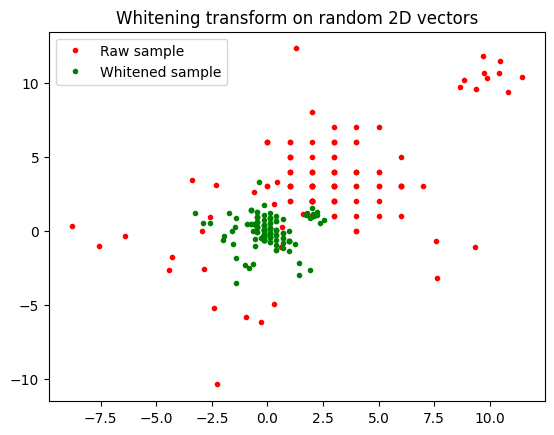

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(sample[0, :], sample[1, :], ".", color="red", label="Raw sample")
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Whitened sample")
ax.legend()
ax.set(**{"title": "Whitening transform on random 2D vectors"});

## Is there a difference between whitening implementations?
The naive method first computes the covariance $\Sigma$,
inverts it, and decomposes it using Cholesky.
The alternative method used by various authors
computes $\Sigma$, regularizes it by blending
it with a diagonal matrix (to make it *numerically*
more likely to be positive definite, I suppose),
decomposes it, and then inverts the triangular matrix.

**Fun fact:** the LWM paper implements the regularization step,
but sets the parameter to 0, basically skipping it. 🤷

**Observation:** only the parameter $\epsilon$ seems to matter?
See plot below.

TODO: compare numerically, and compare computation speed.

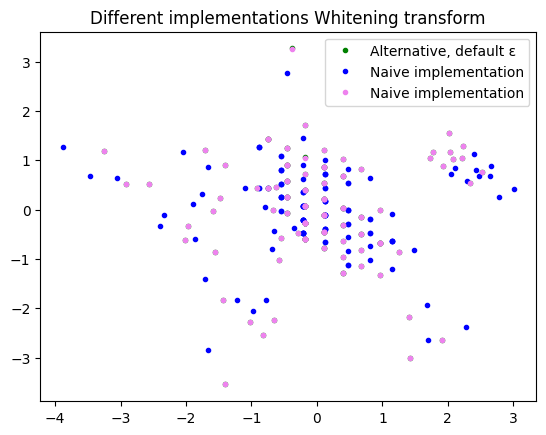

In [12]:
sample_naive_whitened = whiten_naive(sample)
sample_whitened_0_eps = whiten(sample, reg_eps=0)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(whitened_sample[0, :], whitened_sample[1, :], ".", color="green", label="Alternative, default ε")
ax.plot(sample_naive_whitened[0, :], sample_naive_whitened[1, :], ".", color="blue", label="Naive implementation")
ax.plot(sample_whitened_0_eps[0, :], sample_whitened_0_eps[1, :], ".", color="violet", label="Naive implementation")
ax.legend()
ax.set(**{"title": "Different implementations Whitening transform"});